In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
import scipy
import cv2
import os

In [143]:
benign_count = 0
anom_count = 0

In [144]:
def convert_to_images(df, label_name, feature_count):
    global benign_count, anom_count

    counter = 0
    chunk_size = feature_count * 3
    chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    output_dir = os.path.join("converted_images", str(label_name))
    os.makedirs(output_dir, exist_ok=True)

    for idx, chunk in enumerate(chunks):
        if len(chunk) != chunk_size:
            continue

        img = np.zeros((feature_count, feature_count, 3), dtype=np.uint8)

        # Process each channel (R, G, B)
        for channel in range(3):
            channel_data = chunk.iloc[channel*feature_count : (channel+1)*feature_count]
            channel_processed = np.nan_to_num(channel_data, nan=0.0, posinf=255.0, neginf=0.0)
            channel_processed = np.clip(channel_processed, 0, 255).astype(np.uint8)
            img[:, :, channel] = channel_processed

        filename = os.path.join(output_dir, f"{label_name}_{counter}.png")
        cv2.imwrite(filename, img)
        
        if label_name == 'Benign':
            benign_count += 1
        else:
            anom_count += 1
        counter += 1

In [145]:
df = pd.read_parquet(r"C:\Users\John Rome Belocora\Downloads\01-12-20250510T145443Z-1-001\01-12\Syn.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155875 entries, 0 to 155874
Data columns (total 78 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  155875 non-null  int64  
 1   Flow Duration             155875 non-null  int64  
 2   Total Fwd Packets         155875 non-null  int64  
 3   Total Backward Packets    155875 non-null  int64  
 4   Fwd Packets Length Total  155875 non-null  float64
 5   Bwd Packets Length Total  155875 non-null  float64
 6   Fwd Packet Length Max     155875 non-null  float64
 7   Fwd Packet Length Min     155875 non-null  float64
 8   Fwd Packet Length Mean    155875 non-null  float64
 9   Fwd Packet Length Std     155875 non-null  float64
 10  Bwd Packet Length Max     155875 non-null  float64
 11  Bwd Packet Length Min     155875 non-null  float64
 12  Bwd Packet Length Mean    155875 non-null  float64
 13  Bwd Packet Length Std     155875 non-null  f

In [146]:
benign_count = 0
anom_count = 0

In [147]:
print("Unique labels:", df['Label'].unique())

Unique labels: ['Syn' 'BENIGN']


In [148]:
print(df['Label'].value_counts())

Label
Syn       155501
BENIGN       374
Name: count, dtype: int64


In [149]:
# Prepare features and get feature count
label_col = 'Label'
features = df.drop(columns=[label_col])
feature_count = features.shape[1]

In [10]:
# Print initial counts
print(f"Initial Counts - Anomalous: {anom_count}, Benign: {benign_count}")

Initial Counts - Anomalous: 0, Benign: 0


In [11]:
# Process all labels
for label in df[label_col].unique():
    class_data = df[df[label_col] == label].drop(columns=[label_col])
    convert_to_images(class_data, label, feature_count)

print(f"Benign Images After: {benign_count}")
print(f"Anomalous Images After: {anom_count}")

Benign Images After: 0
Anomalous Images After: 674


In [13]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
print(tf.test.is_gpu_available())  

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [14]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Should return True
print(tf.sysconfig.get_build_info())  # Check CUDA/cuDNN versions

True
OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


# EfficientNetV2

In [227]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt

DATA_DIR = r"C:\Users\John Rome Belocora\Downloads\new_converted_images"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Pipeline
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant'
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1122 images belonging to 16 classes.
Found 274 images belonging to 16 classes.


In [ ]:
def create_efficientnet_model(input_shape, num_classes):
    # Load base model
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'  # GlobalAveragePooling
    )
    
    # Freeze base initially
    base_model.trainable = False
    
    # Build model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)  
    x = layers.Dropout(0.6)(x) 
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model, base_model

In [ ]:
def train_model():
    num_classes = len(train_generator.class_indices)
    input_shape = (*IMG_SIZE, 3)
    model, base_model = create_efficientnet_model(input_shape, num_classes)
    
    # optimizer configuration
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # callbacks
    callbacks_list = [
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
    
    print("=== Phase 1: Training Head ===")
    history = model.fit(
        train_generator,
        epochs=30,  
        validation_data=val_generator,
        callbacks=callbacks_list
    )
    
    print("\n=== Phase 2: Fine-Tuning ===")
    base_model.trainable = True
    
    # Recompile with lower LR
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.00001), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(
        train_generator,
        epochs=50,
        initial_epoch=history.epoch[-1] + 1,
        validation_data=val_generator,
        callbacks=callbacks_list
    )
    
    return model

In [230]:
def evaluate_model(model):
    model.load_weights('best_model.h5')
    results = model.evaluate(val_generator)
    print(f"\nTest Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.2%}")

In [232]:
model = train_model()

=== Phase 1: Training Head ===
Epoch 1/30
36/36 [==============================] - 34s 689ms/step - loss: 1.5960 - accuracy: 0.6025 - val_loss: 0.9591 - val_accuracy: 0.8139 - lr: 1.0000e-04
Epoch 2/30
36/36 [==============================] - 21s 561ms/step - loss: 0.9567 - accuracy: 0.7914 - val_loss: 0.6847 - val_accuracy: 0.8248 - lr: 1.0000e-04
Epoch 3/30
36/36 [==============================] - 16s 447ms/step - loss: 0.7256 - accuracy: 0.8191 - val_loss: 0.5306 - val_accuracy: 0.8321 - lr: 1.0000e-04
Epoch 4/30
36/36 [==============================] - 17s 464ms/step - loss: 0.5867 - accuracy: 0.8414 - val_loss: 0.4474 - val_accuracy: 0.8577 - lr: 1.0000e-04
Epoch 5/30
36/36 [==============================] - 17s 470ms/step - loss: 0.4928 - accuracy: 0.8672 - val_loss: 0.3984 - val_accuracy: 0.8869 - lr: 1.0000e-04
Epoch 6/30
36/36 [==============================] - 21s 583ms/step - loss: 0.4680 - accuracy: 0.8672 - val_loss: 0.3479 - val_accuracy: 0.8978 - lr: 1.0000e-04
Epoch 7/3

In [233]:
evaluate_model(model)

9/9 [==============================] - 4s 428ms/step - loss: 0.1442 - accuracy: 0.9234

Test Loss: 0.1442
Test Accuracy: 92.34%


In [297]:
from tensorflow.keras.models import load_model
import tensorflow as tf

try:
    model = load_model(r"C:\Users\John Rome Belocora\Downloads\Models\efficientnetv2_model.h5", compile=False)
    # Recompile if needed (use original settings)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!


In [298]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = r"C:\Users\John Rome Belocora\Downloads\new_converted_images"
img_size = (224, 224)  # Replace with your actual image size

# Validation generator only 
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,  # Match your training batch size
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important for correct label alignment
)

Found 274 images belonging to 16 classes.


In [296]:
# Get the actual classes the model was trained on
model_classes = model.output_shape[-1]  # This gives 12

# Get the validation classes
val_classes = len(val_generator.class_indices)  # This gives 16

# Find the intersection (classes present in both)
common_classes = sorted(list(set(val_generator.class_indices.keys()) & set(range(model_classes)))[:model_classes])

# Generate report with matching classes
print(classification_report(y_true, y_pred_classes, 
                          labels=range(model_classes),
                          target_names=[class_names[i] for i in range(model_classes)],
                          digits=4))

               precision    recall  f1-score   support

    DrDoS_DNS     1.0000    0.6667    0.8000         3
   DrDoS_LDAP     0.0000    0.0000    0.0000         1
  DrDoS_MSSQL     0.5000    0.4000    0.4444         5
    DrDoS_NTP     1.0000    1.0000    1.0000       105
DrDoS_NetBIOS     0.0000    0.0000    0.0000         0
   DrDoS_SNMP     0.0000    0.0000    0.0000         2
    DrDoS_UDP     0.7143    0.5556    0.6250         9
         LDAP     0.0000    0.0000    0.0000         1
        MSSQL     0.4615    0.8571    0.6000         7
      NetBIOS     0.0000    0.0000    0.0000         0
      Portmap     0.0000    0.0000    0.0000         0
          Syn     1.0000    1.0000    1.0000        37
         TFTP     1.0000    0.9765    0.9881        85
          UDP     0.6250    0.8333    0.7143        12
      UDP-lag     1.0000    1.0000    1.0000         7
      WebDDoS     0.0000    0.0000    0.0000         0

     accuracy                         0.9380       274
    macr

c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\John Rome Belocora\anaconda3\envs\tf_win_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

1/1 [==============================] - 0s 32ms/step


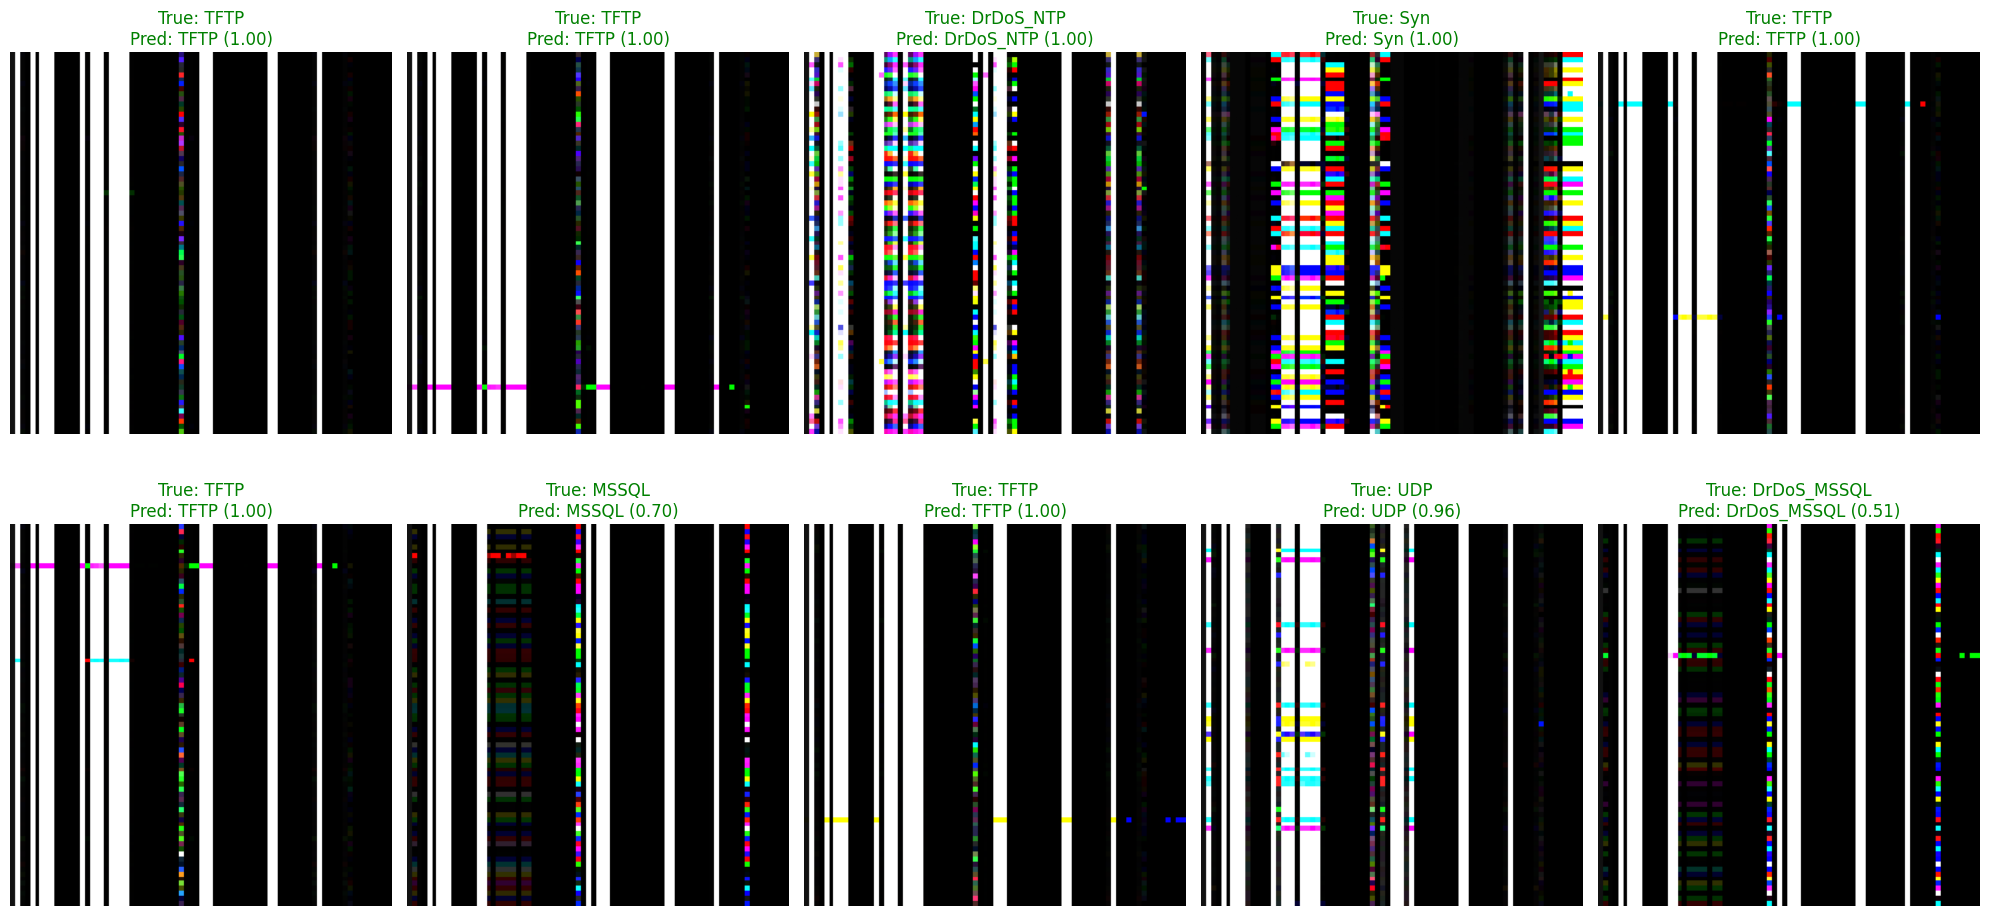

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

def predict_attack_type(img_path, model):
    # Load and preprocess image specifically for EfficientNetV2
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array) 
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    
    # Get class labels from your validation generator
    class_labels = list(val_generator.class_indices.keys())
    return class_labels[class_idx], pred[0][class_idx]

def visualize_predictions(test_images_dir, model, num_samples=10, img_size=(224, 224)):
    # Get all image files
    image_files = []
    for root, dirs, files in os.walk(test_images_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    
    if not image_files:
        print(f"No images found in {test_images_dir}")
        return
    
    # Select random samples
    selected_images = np.random.choice(image_files, size=min(num_samples, len(image_files)), replace=False)
    
    # Create figure
    fig, axes = plt.subplots(2, (num_samples + 1) // 2, figsize=(20, 10))
    axes = axes.flat
    
    for i, img_path in enumerate(selected_images):
        if i >= len(axes):
            break
            
        try:
            # Make prediction
            true_label = os.path.basename(os.path.dirname(img_path))
            predicted_label, confidence = predict_attack_type(img_path, model)

            # Load and plot the image
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img) / 255.0  
            axes[i].imshow(img_array)
            
            # Set title based on prediction
            color = "green" if predicted_label == true_label else "red"
            axes[i].set_title(f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f})", color=color)
            axes[i].axis("off")
        
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            axes[i].axis("off")
            axes[i].set_title("Error loading image")
    
    plt.tight_layout()
    plt.show()

visualize_predictions(
    test_images_dir=r"C:\Users\John Rome Belocora\Downloads\new_converted_images",
    model=model,  
    img_size=img_size
)